In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import seaborn as sns

from tqdm import tqdm, trange
import pickle
from sklearn.linear_model import LogisticRegression as lreg
from sklearn.model_selection import train_test_split


from joblib import Parallel, delayed
import seaborn as sns
sns.set_style("ticks")
sns.set_context("talk", font_scale=0.9)
sns.set_style({"ytick.direction": "in"})
sns.set_style({"xtick.direction": "in"})


#from sklearn.linear_model import LinearRegression as lreg
clf = lreg(max_iter=3000)


In [2]:
time_data = np.loadtxt("../Data/time_25ms.txt")
dec_range = np.where((time_data > -0.5) & (time_data<0.25))[0]

f = open("../Data/decoders/pseudo_regression_A1_PFC_dec_25ms.pickle","rb")
all_decs = pickle.load(f)



f = '/Users/jbarbosa/Dropbox/Neuro/papers/rodgers_deweese/multi_area/simulation_trials_1000_shared_1_private_1_fourth_ind_0.05_shared_1.pickle'
with open(f, 'rb') as pickle_file:
    [X,trial_stims,vecs] = pickle.load(pickle_file)

# with open("simulation_trials_500_no_ind_noise.pickle", 'rb') as pickle_file:
#     [X,trial_stims,vecs] = pickle.load(pickle_file)


# with open("simulation_trials_500_no_shared_noise.pickle", 'rb') as pickle_file:
#     [X,trial_stims,vecs] = pickle.load(pickle_file)

# # remove last contex inputs that is not used
stims_pars_trial = np.array(list(trial_stims[:,0]))[:,:]

N=3000
trials = len(trial_stims)
n_pops = 3

In [3]:
decisions =  stims_pars_trial[:,-1]
context =  stims_pars_trial[:,-3]

IA =  stims_pars_trial[:,0]
IB =  stims_pars_trial[:,1]

In [4]:

dt=0.01
T_DUR = 7
time = np.arange(0,T_DUR,dt)

n_folds = 20


In [5]:

from tqdm import trange
clf = lreg(max_iter=3000)


def decode(data,y):

    def one_time(data,y):
        scores = []
        for f in range(n_folds):
            #idx = np.random.choice(range(1500),100)
            X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.5)
            clf.fit(X_train,y_train)
            scores.append(clf.score(X_test,y_test))
        return scores

    all_scores = np.zeros([200,n_folds])
    
    for t in trange(100,300):
        all_scores[t-100,:] =  one_time(data[t],y)

    return all_scores
        

In [6]:
X_ctx_A = X[:,context==1]
X_ctx_B = X[:,context==0]

X_ctx_A -= torch.mean(X_ctx_A,1)[:,None,:]
X_ctx_B -= torch.mean(X_ctx_B,1)[:,None,:]

X_ctx_A /= torch.std(X_ctx_A,1)[:,None,:]
X_ctx_B /= torch.std(X_ctx_B,1)[:,None,:]

A1_scores_IA_A = decode(X_ctx_B[:1500].T,IA[context==0])
A1_scores_IA_B = decode(X_ctx_A[:1500].T,IA[context==1])
A1_scores_context = decode(X[:1500].T,context)

PFC_scores_IA_A = decode(X_ctx_B[1500:].T,IA[context==0])
PFC_scores_IA_B = decode(X_ctx_A[1500:].T,IA[context==1])
PFC_scores_context = decode(X[1500:].T,context)


/var/folders/6w/snfd5vc50jb775fq8364m1d80000gn/T/ipykernel_40677/3919440732.py:10: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3281.)
  A1_scores_IA_A = decode(X_ctx_B[:1500].T,IA[context==0])
100%|██████████| 200/200 [03:16<00:00,  1.02it/s]


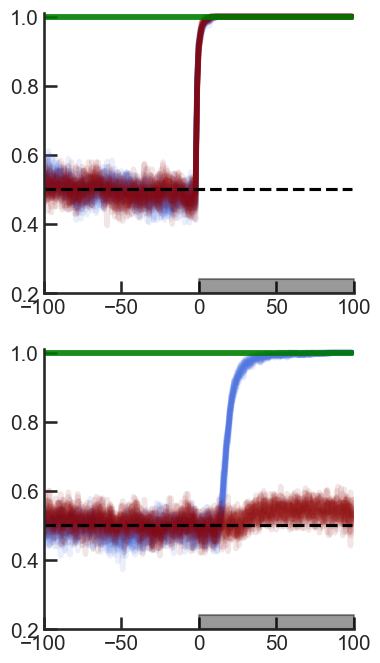

In [7]:
plt.figure(figsize=(4,8))

time = np.arange(200)-100
plt.subplot(2,1,1)
plt.plot(time,A1_scores_IA_B,color='royalblue',alpha=0.1,lw=4)
plt.plot(time,A1_scores_IA_A,color='darkred',alpha=0.1,lw=4)
plt.plot(time,A1_scores_context,color='green',alpha=0.1,lw=4)

plt.plot(time,np.ones_like(time)*0.5,'k--')
plt.fill_between([0,100],[0.2,0.2],[0.24,0.24],color='black',alpha=0.4)
plt.ylim(0.2,1.01)
plt.xlim(-100,100)

plt.subplot(2,1,2)
plt.plot(time,PFC_scores_IA_B,color='royalblue',alpha=0.1,lw=4)
plt.plot(time,PFC_scores_IA_A,color='darkred',alpha=0.1,lw=4)
plt.plot(time,PFC_scores_context,color='green',alpha=0.1,lw=4)

plt.plot(time,np.ones_like(time)*0.5,'k--')
plt.fill_between([0,100],[0.2,0.2],[0.24,0.24],color='black',alpha=0.4)
plt.ylim(0.2,1.01)
plt.xlim(-100,100)
sns.despine()

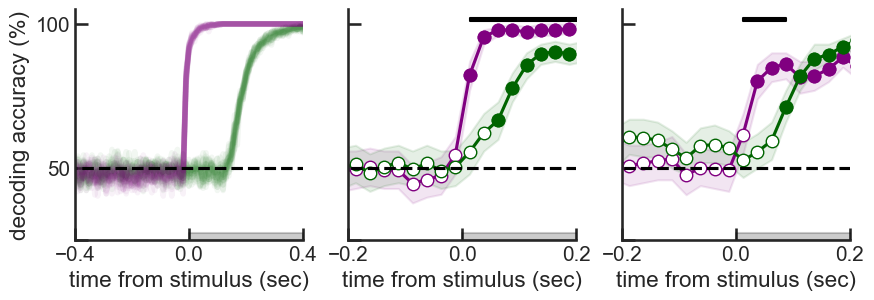

In [73]:

plt.figure(figsize=(10,3))

plt.subplot(1,3,1)
plt.plot(time*0.01,PFC_scores_IA_B,color='darkgreen',alpha=0.05,lw=4)
plt.plot(time*0.01,A1_scores_IA_B,color='purple',alpha=0.05,lw=4)


plt.ylim(0.25,1.05)
plt.yticks([0.25,0.5,1],[])
plt.xlim(-0.4,0.4)
plt.xticks([-0.4,0,0.4])
plt.plot([-100,100],[0.5,0.5],"k--")

plt.xlabel("time from stimulus (sec)")
plt.fill_between([0,.4],[0.25,0.25],[.275,.275],color="black",alpha=0.2)
plt.ylabel("decoding accuracy (%)")
plt.yticks([0.25,0.5,1],["",50,100])

sns.despine()


p_a1_pfc_loc = np.mean(np.mean(all_decs[0,:,0,0],0) < all_decs[1,:,0,0],0) <= 0.1
p_a1_pfc_pitch = np.mean(np.mean(all_decs[0,:,1,1],0) < all_decs[1,:,1,1],0) <= 0.1

p_a1_pfc = [np.where(p_a1_pfc_loc)[0],np.where(p_a1_pfc_pitch)[0]]

colors = ['purple','darkgreen']
labels = ['A1', 'mPFC']
for stim in [0,1]:
    plt.subplot(1,3,2+stim)

    plt.fill_between(time_data[dec_range][p_a1_pfc[stim]],1.01*np.ones_like(p_a1_pfc[stim]),1.02*np.ones_like(p_a1_pfc[stim]),color="black")

    for ai in [0,1]:
        ps = np.array([np.percentile(a,2.5) for a in all_decs[ai,:,stim,stim].T])>.5
        err_bars = np.array([np.percentile(a,[16,84]) for a in all_decs[ai,:,stim,stim].T])
        plt.fill_between(time_data[dec_range],err_bars[:,0],err_bars[:,1],color=colors[ai],alpha=0.1,label=labels[ai])
        plt.plot(time_data[dec_range],np.mean(all_decs[ai,:,stim,stim],0),color=colors[ai])
        plt.plot(time_data[dec_range],np.mean(all_decs[ai,:,stim,stim],0),"o",markerfacecolor='white',color=colors[ai], label="not sig.")
        plt.plot(time_data[dec_range][ps],np.mean(all_decs[ai,:,stim,stim],0)[ps],"o",color=colors[ai], label="sig.")

    plt.fill_between([0,.25],[0.25,0.25],[.275,.275],color="black",alpha=0.2)
    plt.ylim(0.25,1.05)
    plt.yticks([0.25,0.5,1],[])
    plt.xlim(-0.2,0.2)
    plt.xticks([-0.2,0,0.2])
    plt.plot(time_data[dec_range],np.ones_like(time_data[dec_range])*0.5,"k--")

    plt.xlabel("time from stimulus (sec)")
    

sns.despine()

plt.savefig("figures/Fig5_stiming.svg")


In [67]:
5

5